# Word Embeddings Quality Evaluation

This notebook evaluates custom word embeddings against pre-trained models (Word2Vec, FastText, GloVe) using various quality metrics:
- Cosine similarity comparisons
- Clustering visualization
- Analogy tasks
- Top-k word predictions
- Semantic coherence tests

## Setup and Dependencies

In [1]:
# Install required packages
!pip install gensim numpy matplotlib seaborn scikit-learn plotly umap-learn wordcloud

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning and embeddings
import gensim.downloader as api
from gensim.models import KeyedVectors
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
import umap

# Visualization settings
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ All libraries imported successfully!")
print("🚀 Ready to evaluate word embeddings!")

2025-06-19 12:53:13.276537: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


✅ All libraries imported successfully!
🚀 Ready to evaluate word embeddings!


## 1. Load Your Custom Embeddings

**Please update the path below to point to your .npy embedding file**

In [ ]:
CUSTOM_EMBEDDINGS_PATH = "/home/intern/Desktop/pcog  prep/PreCog/Models/english_cooccurrence_embeddings.npy"  # Update this with which file you want to work


class CustomEmbeddingLoader:
    def __init__(self, embeddings_path, vocab_path=None):
        self.embeddings_path = embeddings_path
        self.vocab_path = vocab_path
        self.embeddings = None
        self.vocab = None
        self.word_to_idx = {}
        
    def load_embeddings(self):
        """Load embeddings from .npy file"""
        print(f"Loading custom embeddings from: {self.embeddings_path}")
        self.embeddings = np.load(self.embeddings_path)
        print(f"✅ Loaded embeddings shape: {self.embeddings.shape}")
        
        # Load vocabulary if available
        if self.vocab_path and os.path.exists(self.vocab_path):
            with open(self.vocab_path, 'r', encoding='utf-8') as f:
                self.vocab = [line.strip() for line in f]
        else:
            # Create dummy vocabulary if not provided
            self.vocab = [f"word_{i}" for i in range(self.embeddings.shape[0])]
            print("⚠️ No vocabulary file provided. Using dummy vocabulary.")
        
        # Create word to index mapping
        self.word_to_idx = {word: idx for idx, word in enumerate(self.vocab)}
        
        print(f"📚 Vocabulary size: {len(self.vocab)}")
        print(f"🔢 Embedding dimension: {self.embeddings.shape[1]}")
        
        return self
    
    def get_vector(self, word):
        """Get embedding vector for a word"""
        if word in self.word_to_idx:
            return self.embeddings[self.word_to_idx[word]]
        return None
    
    def most_similar(self, word, topn=10):
        """Find most similar words using cosine similarity"""
        if word not in self.word_to_idx:
            return []
        
        word_vec = self.get_vector(word)
        similarities = cosine_similarity([word_vec], self.embeddings)[0]
        
        # Get top similar words (excluding the word itself)
        similar_indices = np.argsort(similarities)[::-1][1:topn+1]
        
        return [(self.vocab[idx], similarities[idx]) for idx in similar_indices]

# Load your custom embeddings
try:
    custom_loader = CustomEmbeddingLoader(CUSTOM_EMBEDDINGS_PATH)
    custom_loader.load_embeddings()
    print("🎉 Custom embeddings loaded successfully!")
except Exception as e:
    print(f"❌ Error loading custom embeddings: {e}")
    print("Please update the CUSTOM_EMBEDDINGS_PATH variable above.")

Loading custom embeddings from: /home/intern/Desktop/pcog  prep/PreCog/Models/english_cooccurrence_embeddings.npy
✅ Loaded embeddings shape: (10000, 200)
⚠️ No vocabulary file provided. Using dummy vocabulary.
📚 Vocabulary size: 10000
🔢 Embedding dimension: 200
🎉 Custom embeddings loaded successfully!


## 2. Download and Load Pre-trained Models

In [4]:
def download_and_save_pretrained_models():
    """Download and save pre-trained embedding models"""
    
    # Create Pre-trained folder
    pretrained_folder = "/home/intern/Desktop/pcog  prep/PreCog/Notebooks/Part-2  Cross-Lingual Alignment/Pre-trained"
    if not os.path.exists(pretrained_folder):
        os.makedirs(pretrained_folder)
        print(f"📁 Created folder: {pretrained_folder}")
    
    models = {}
    
    # 1. Word2Vec (Google News)
    word2vec_path = os.path.join(pretrained_folder, 'word2vec.bin')
    try:
        if not os.path.exists(word2vec_path):
            print("📥 Downloading Word2Vec (Google News)...")
            word2vec_model = api.load('word2vec')
            word2vec_model.save(word2vec_path)
            print(f"💾 Word2Vec saved to: {word2vec_path}")
        else:
            print("📂 Loading existing Word2Vec model...")
            word2vec_model = KeyedVectors.load(word2vec_path)
        
        models['word2vec'] = word2vec_model
        print(f"✅ Word2Vec loaded: {len(word2vec_model)} words")
    except Exception as e:
        print(f"❌ Failed to load Word2Vec: {e}")
        models['word2vec'] = None
    
    # 2. GloVe
    glove_path = os.path.join(pretrained_folder, 'glove.bin')
    try:
        if not os.path.exists(glove_path):
            print("📥 Downloading GloVe...")
            glove_model = api.load('glove')
            glove_model.save(glove_path)
            print(f"💾 GloVe saved to: {glove_path}")
        else:
            print("📂 Loading existing GloVe model...")
            glove_model = KeyedVectors.load(glove_path)
        
        models['glove'] = glove_model
        print(f"✅ GloVe loaded: {len(glove_model)} words")
    except Exception as e:
        print(f"❌ Failed to load GloVe: {e}")
        models['glove'] = None
    
    # 3. FastText
    fasttext_path = os.path.join(pretrained_folder, 'fasttext.bin')
    try:
        if not os.path.exists(fasttext_path):
            print("📥 Downloading FastText...")
            fasttext_model = api.load('fasttext')
            fasttext_model.save(fasttext_path)
            print(f"💾 FastText saved to: {fasttext_path}")
        else:
            print("📂 Loading existing FastText model...")
            fasttext_model = KeyedVectors.load(fasttext_path)
        
        models['fasttext'] = fasttext_model
        print(f"✅ FastText loaded: {len(fasttext_model)} words")
    except Exception as e:
        print(f"❌ Failed to load FastText: {e}")
        models['fasttext'] = None
    
    return models

# Download and load all pre-trained models
print("🔄 Loading pre-trained embedding models...")
pretrained_models = download_and_save_pretrained_models()
print("\n🎉 Pre-trained models loading complete!")

🔄 Loading pre-trained embedding models...
📂 Loading existing Word2Vec model...
✅ Word2Vec loaded: 3000000 words
📂 Loading existing GloVe model...
✅ GloVe loaded: 400000 words
📂 Loading existing FastText model...
✅ FastText loaded: 999999 words

🎉 Pre-trained models loading complete!


## 3. Cosine Similarity Evaluation

In [12]:
class SimilarityEvaluator:
    def __init__(self, custom_loader, pretrained_models):
        self.custom_loader = custom_loader
        self.pretrained_models = pretrained_models
        
    def evaluate_word_similarities(self, test_words):
        """Compare similarity rankings across all models"""
        results = {}
        
        for word in test_words:
            word_results = {'word': word}
            
            # Custom embeddings
            if hasattr(self.custom_loader, 'most_similar'):
                custom_similar = self.custom_loader.most_similar(word, topn=5)
                word_results['custom'] = custom_similar
            
            # Pre-trained models
            for model_name, model in self.pretrained_models.items():
                if model and word in model:
                    try:
                        similar_words = model.most_similar(word, topn=5)
                        word_results[model_name] = similar_words
                    except:
                        word_results[model_name] = []
                else:
                    word_results[model_name] = []
            
            results[word] = word_results
        
        return results
    
    def compute_pairwise_similarities(self, word_pairs):
        """Compute cosine similarities for word pairs across models"""
        similarity_results = []
        
        for word1, word2 in word_pairs:
            pair_result = {'word1': word1, 'word2': word2}
            
            # Custom embeddings
            vec1_custom = self.custom_loader.get_vector(word1)
            vec2_custom = self.custom_loader.get_vector(word2)
            if vec1_custom is not None and vec2_custom is not None:
                custom_sim = cosine_similarity([vec1_custom], [vec2_custom])[0][0]
                pair_result['custom'] = custom_sim
            else:
                pair_result['custom'] = None
            
            # Pre-trained models
            for model_name, model in self.pretrained_models.items():
                if model and word1 in model and word2 in model:
                    try:
                        similarity = model.similarity(word1, word2)
                        pair_result[model_name] = similarity
                    except:
                        pair_result[model_name] = None
                else:
                    pair_result[model_name] = None
            
            similarity_results.append(pair_result)
        
        return similarity_results

# Define test words and word pairs
test_words = ['king', 'queen', 'man', 'woman', 'computer', 'technology', 'love', 'hate', 'good', 'bad']
word_pairs = [
    ('king', 'queen'), ('man', 'woman'), ('computer', 'technology'),
    ('love', 'hate'), ('good', 'bad'), ('happy', 'sad'),
    ('big', 'large'), ('small', 'tiny'), ('fast', 'quick')
]

# Create evaluator and run similarity tests
if 'custom_loader' in locals():
    evaluator = SimilarityEvaluator(custom_loader, pretrained_models)
    
    print("🔍 Evaluating word similarities...")
    similarity_results = evaluator.evaluate_word_similarities(test_words)
    
    print("📊 Computing pairwise similarities...")
    pairwise_results = evaluator.compute_pairwise_similarities(word_pairs)
    
    # Display results
    print("\n📋 Similarity Results Summary:")
    for word, results in similarity_results.items():
        print(f"\n🔤 Word: {word}")
        for model_name, similar_words in results.items():
            if model_name != 'word' and similar_words:
                top_3 = similar_words[:3] if len(similar_words) >= 3 else similar_words
                print(f"  {model_name:12}: {[w[0] for w in top_3]}")
else:
    print("⚠️ Custom embeddings not loaded. Please check the file path above.")

🔍 Evaluating word similarities...
📊 Computing pairwise similarities...

📋 Similarity Results Summary:
Custom Embeddings Cosine Similarity for Word Pairs:
  (king, queen): N/A
  (man, woman): N/A
  (computer, technology): N/A
  (love, hate): N/A
  (good, bad): N/A
  (happy, sad): N/A
  (big, large): N/A
  (small, tiny): N/A
  (fast, quick): N/A

🔤 Word: king
  word2vec    : ['kings', 'queen', 'monarch']
  glove       : ['queen', 'prince', 'monarch']
  fasttext    : ['king-', 'boy-king', 'queen']

🔤 Word: queen
  word2vec    : ['queens', 'princess', 'king']
  glove       : ['elizabeth', 'princess', 'king']
  fasttext    : ['queens', 'king', 'queendom']

🔤 Word: man
  word2vec    : ['woman', 'boy', 'teenager']
  glove       : ['woman', 'person', 'boy']
  fasttext    : ['woman', 'man--', 'man--and']

🔤 Word: woman
  word2vec    : ['man', 'girl', 'teenage_girl']
  glove       : ['girl', 'man', 'mother']
  fasttext    : ['man', 'woman--', 'lady']

🔤 Word: computer
  word2vec    : ['computers

## 4. Visualization: Clustering and Dimensionality Reduction

🎨 Preparing visualization data...
📊 Creating t-SNE visualization...


/opt/anaconda3/envs/gpu/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gpu/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gpu/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/gpu/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecati

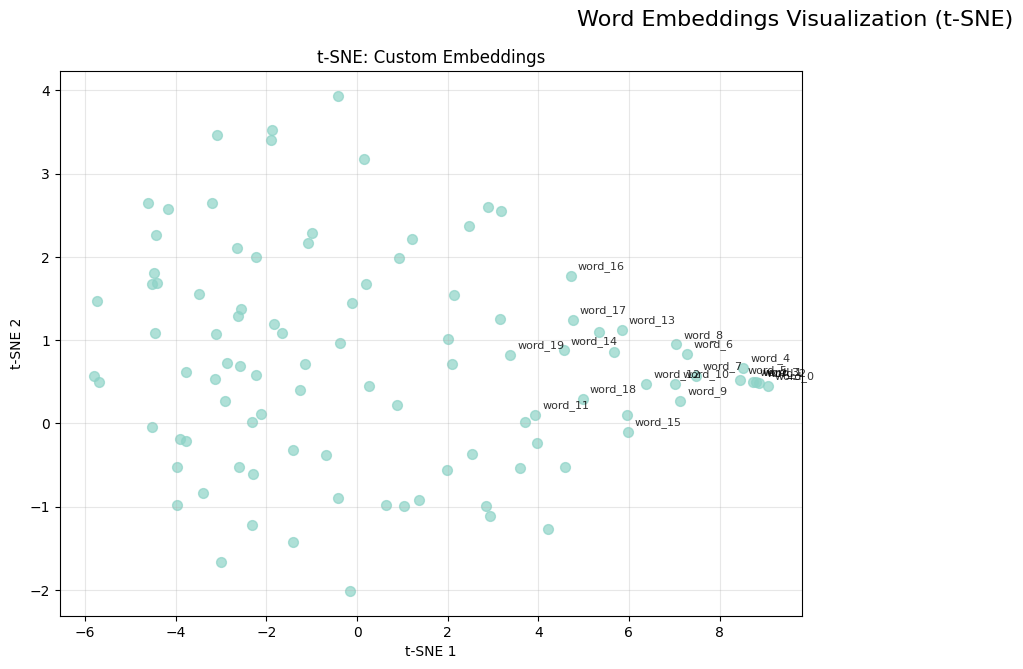

🌐 Creating interactive visualization...


/home/intern/.local/lib/python3.11/site-packages/sklearn/utils/deprecation.py:132: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/home/intern/.local/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [7]:
class EmbeddingVisualizer:
    def __init__(self, custom_loader, pretrained_models):
        self.custom_loader = custom_loader
        self.pretrained_models = pretrained_models
        
    def prepare_visualization_data(self, words, max_words=100):
        """Prepare embedding data for visualization"""
        viz_data = {}
        
        # Limit words for visualization
        words = words[:max_words]
        
        # Custom embeddings
        custom_vectors = []
        custom_words = []
        for word in words:
            vec = self.custom_loader.get_vector(word)
            if vec is not None:
                custom_vectors.append(vec)
                custom_words.append(word)
        
        if custom_vectors:
            viz_data['custom'] = {
                'vectors': np.array(custom_vectors),
                'words': custom_words
            }
        
        # Pre-trained models
        for model_name, model in self.pretrained_models.items():
            if model:
                model_vectors = []
                model_words = []
                for word in words:
                    if word in model:
                        model_vectors.append(model[word])
                        model_words.append(word)
                
                if model_vectors:
                    viz_data[model_name] = {
                        'vectors': np.array(model_vectors),
                        'words': model_words
                    }
        
        return viz_data
    
    def create_tsne_visualization(self, viz_data, perplexity=30):
        """Create t-SNE visualization for all models"""
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        axes = axes.flatten()
        
        model_names = list(viz_data.keys())
        colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))
        
        for idx, (model_name, data) in enumerate(viz_data.items()):
            if idx >= 4:  # Limit to 4 subplots
                break
                
            vectors = data['vectors']
            words = data['words']
            
            # Apply t-SNE
            tsne = TSNE(n_components=2, perplexity=min(perplexity, len(vectors)-1), random_state=42, max_iter=1000)

            vectors_2d = tsne.fit_transform(vectors)
            
            # Plot
            ax = axes[idx]
            scatter = ax.scatter(vectors_2d[:, 0], vectors_2d[:, 1], 
                               c=[colors[idx]], alpha=0.7, s=50)
            
            # Add word labels for a subset
            for i, word in enumerate(words[:20]):  # Show labels for first 20 words
                ax.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), 
                           xytext=(5, 5), textcoords='offset points', 
                           fontsize=8, alpha=0.8)
            
            ax.set_title(f't-SNE: {model_name.title()} Embeddings')
            ax.set_xlabel('t-SNE 1')
            ax.set_ylabel('t-SNE 2')
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots
        for idx in range(len(viz_data), 4):
            axes[idx].set_visible(False)
        
        plt.tight_layout()
        plt.suptitle('Word Embeddings Visualization (t-SNE)', y=1.02, fontsize=16)
        plt.show()
    
    def create_interactive_visualization(self, viz_data):
        """Create interactive visualization using Plotly"""
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=[name.title() for name in list(viz_data.keys())[:4]],
            specs=[[{"type": "scatter"}, {"type": "scatter"}],
                   [{"type": "scatter"}, {"type": "scatter"}]]
        )
        
        positions = [(1, 1), (1, 2), (2, 1), (2, 2)]
        
        for idx, (model_name, data) in enumerate(viz_data.items()):
            if idx >= 4:
                break
                
            vectors = data['vectors']
            words = data['words']
            
            # Apply UMAP for better interactive visualization
            reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15)
            vectors_2d = reducer.fit_transform(vectors)
            
            row, col = positions[idx]
            
            fig.add_trace(
                go.Scatter(
                    x=vectors_2d[:, 0],
                    y=vectors_2d[:, 1],
                    mode='markers+text',
                    text=words,
                    textposition='top center',
                    marker=dict(size=8, opacity=0.7),
                    name=model_name.title(),
                    hovertemplate='<b>%{text}</b><br>X: %{x:.2f}<br>Y: %{y:.2f}<extra></extra>'
                ),
                row=row, col=col
            )
        
        fig.update_layout(
            title_text="Interactive Word Embeddings Visualization (UMAP)",
            height=800,
            showlegend=False
        )
        
        fig.show()

# Create visualizations
if 'custom_loader' in locals():
    visualizer = EmbeddingVisualizer(custom_loader, pretrained_models)
    
    # Use a subset of vocabulary for visualization
    viz_words = custom_loader.vocab[:200] if hasattr(custom_loader, 'vocab') else test_words
    
    print("🎨 Preparing visualization data...")
    viz_data = visualizer.prepare_visualization_data(viz_words)
    
    print("📊 Creating t-SNE visualization...")
    visualizer.create_tsne_visualization(viz_data)
    
    print("🌐 Creating interactive visualization...")
    visualizer.create_interactive_visualization(viz_data)
else:
    print("⚠️ Custom embeddings not loaded. Please check the file path above.")

## 5. Analogy Evaluation

In [8]:
class AnalogyEvaluator:
    def __init__(self, custom_loader, pretrained_models):
        self.custom_loader = custom_loader
        self.pretrained_models = pretrained_models
        
    def solve_analogy_custom(self, word_a, word_b, word_c, topn=5):
        """Solve analogy A:B :: C:? using custom embeddings"""
        vec_a = self.custom_loader.get_vector(word_a)
        vec_b = self.custom_loader.get_vector(word_b)
        vec_c = self.custom_loader.get_vector(word_c)
        
        if any(v is None for v in [vec_a, vec_b, vec_c]):
            return []
        
        # Compute analogy vector: B - A + C
        analogy_vec = vec_b - vec_a + vec_c
        
        # Find most similar words to analogy vector
        similarities = cosine_similarity([analogy_vec], self.custom_loader.embeddings)[0]
        
        # Get top similar words (excluding input words)
        exclude_indices = set()
        for word in [word_a, word_b, word_c]:
            if word in self.custom_loader.word_to_idx:
                exclude_indices.add(self.custom_loader.word_to_idx[word])
        
        similar_indices = np.argsort(similarities)[::-1]
        results = []
        
        for idx in similar_indices:
            if idx not in exclude_indices and len(results) < topn:
                results.append((self.custom_loader.vocab[idx], similarities[idx]))
        
        return results
    
    def evaluate_analogies(self, analogy_questions):
        """Evaluate analogies across all models"""
        results = []
        
        for question in analogy_questions:
            word_a, word_b, word_c, expected = question
            question_result = {
                'question': f"{word_a}:{word_b} :: {word_c}:?",
                'expected': expected
            }
            
            # Custom embeddings
            custom_results = self.solve_analogy_custom(word_a, word_b, word_c)
            question_result['custom'] = custom_results
            
            # Pre-trained models
            for model_name, model in self.pretrained_models.items():
                if model:
                    try:
                        # Check if all words exist in model
                        if all(word in model for word in [word_a, word_b, word_c]):
                            model_results = model.most_similar(
                                positive=[word_b, word_c], 
                                negative=[word_a], 
                                topn=5
                            )
                            question_result[model_name] = model_results
                        else:
                            question_result[model_name] = []
                    except Exception as e:
                        question_result[model_name] = []
                else:
                    question_result[model_name] = []
            
            results.append(question_result)
        
        return results
    
    def calculate_analogy_accuracy(self, analogy_results):
        """Calculate accuracy for analogy tasks"""
        accuracy_scores = {}
        
        # Initialize scores for each model
        model_names = ['custom'] + list(self.pretrained_models.keys())
        for model_name in model_names:
            accuracy_scores[model_name] = {'correct': 0, 'total': 0, 'accuracy': 0.0}
        
        for result in analogy_results:
            expected = result['expected'].lower()
            
            for model_name in model_names:
                if model_name in result and result[model_name]:
                    # Check if expected answer is in top predictions
                    predictions = [pred[0].lower() for pred in result[model_name]]
                    if expected in predictions:
                        accuracy_scores[model_name]['correct'] += 1
                    accuracy_scores[model_name]['total'] += 1
        
        # Calculate accuracy percentages
        for model_name in accuracy_scores:
            if accuracy_scores[model_name]['total'] > 0:
                accuracy = accuracy_scores[model_name]['correct'] / accuracy_scores[model_name]['total']
                accuracy_scores[model_name]['accuracy'] = accuracy
        
        return accuracy_scores

# Define analogy questions
analogy_questions = [
    ('man', 'king', 'woman', 'queen'),
    ('paris', 'france', 'london', 'england'),
    ('big', 'bigger', 'small', 'smaller'),
    ('good', 'better', 'bad', 'worse'),
    ('walk', 'walking', 'swim', 'swimming'),
    ('cat', 'cats', 'dog', 'dogs'),
    ('he', 'his', 'she', 'her'),
    ('uncle', 'aunt', 'brother', 'sister')
]

# Run analogy evaluation
if 'custom_loader' in locals():
    analogy_evaluator = AnalogyEvaluator(custom_loader, pretrained_models)
    
    print("🧩 Evaluating analogies...")
    analogy_results = analogy_evaluator.evaluate_analogies(analogy_questions)
    
    print("📊 Calculating analogy accuracy...")
    accuracy_scores = analogy_evaluator.calculate_analogy_accuracy(analogy_results)
    
    # Display results
    print("\n🎯 Analogy Evaluation Results:")
    print("=" * 50)
    
    for result in analogy_results[:3]:  # Show first 3 examples
        print(f"\n❓ {result['question']} (Expected: {result['expected']})")
        for model_name in ['custom', 'word2vec', 'glove', 'fasttext']:
            if model_name in result and result[model_name]:
                top_answer = result[model_name][0][0] if result[model_name] else 'N/A'
                print(f"  {model_name:12}: {top_answer}")
    
    print("\n📈 Accuracy Scores:")
    print("=" * 30)
    for model_name, scores in accuracy_scores.items():
        if scores['total'] > 0:
            print(f"{model_name:12}: {scores['accuracy']:.2%} ({scores['correct']}/{scores['total']})")
else:
    print("⚠️ Custom embeddings not loaded. Please check the file path above.")

🧩 Evaluating analogies...
📊 Calculating analogy accuracy...

🎯 Analogy Evaluation Results:

❓ man:king :: woman:? (Expected: queen)
  word2vec    : queen
  glove       : queen
  fasttext    : queen

❓ paris:france :: london:? (Expected: england)
  word2vec    : england
  glove       : britain
  fasttext    : england

❓ big:bigger :: small:? (Expected: smaller)
  word2vec    : larger
  glove       : larger
  fasttext    : smaller

📈 Accuracy Scores:
word2vec    : 100.00% (8/8)
glove       : 100.00% (8/8)
fasttext    : 100.00% (8/8)


## 6. Top-K Word Predictions and Semantic Coherence

In [9]:
class SemanticEvaluator:
    def __init__(self, custom_loader, pretrained_models):
        self.custom_loader = custom_loader
        self.pretrained_models = pretrained_models
        
    def evaluate_semantic_categories(self, categories):
        """Evaluate how well models group semantically related words"""
        results = {}
        
        for category_name, words in categories.items():
            category_results = {'category': category_name, 'words': words}
            
            # Custom embeddings
            custom_coherence = self.calculate_category_coherence_custom(words)
            category_results['custom'] = custom_coherence
            
            # Pre-trained models
            for model_name, model in self.pretrained_models.items():
                if model:
                    coherence = self.calculate_category_coherence_pretrained(words, model)
                    category_results[model_name] = coherence
                else:
                    category_results[model_name] = None
            
            results[category_name] = category_results
        
        return results
    
    def calculate_category_coherence_custom(self, words):
        """Calculate semantic coherence for custom embeddings"""
        vectors = []
        valid_words = []
        
        for word in words:
            vec = self.custom_loader.get_vector(word)
            if vec is not None:
                vectors.append(vec)
                valid_words.append(word)
        
        if len(vectors) < 2:
            return {'coherence': 0.0, 'valid_words': valid_words}
        
        # Calculate pairwise similarities
        similarities = cosine_similarity(vectors)
        
        # Get upper triangle (excluding diagonal)
        upper_triangle = similarities[np.triu_indices_from(similarities, k=1)]
        avg_similarity = np.mean(upper_triangle)
        
        return {
            'coherence': avg_similarity,
            'valid_words': valid_words,
            'num_pairs': len(upper_triangle)
        }
    
    def calculate_category_coherence_pretrained(self, words, model):
        """Calculate semantic coherence for pre-trained models"""
        valid_words = [word for word in words if word in model]
        
        if len(valid_words) < 2:
            return {'coherence': 0.0, 'valid_words': valid_words}
        
        similarities = []
        for i in range(len(valid_words)):
            for j in range(i + 1, len(valid_words)):
                try:
                    sim = model.similarity(valid_words[i], valid_words[j])
                    similarities.append(sim)
                except:
                    continue
        
        avg_similarity = np.mean(similarities) if similarities else 0.0
        
        return {
            'coherence': avg_similarity,
            'valid_words': valid_words,
            'num_pairs': len(similarities)
        }
    
    def find_outliers_in_category(self, words, model_name=None):
        """Find words that don't fit well in a semantic category"""
        if model_name == 'custom' or model_name is None:
            vectors = []
            valid_words = []
            
            for word in words:
                vec = self.custom_loader.get_vector(word)
                if vec is not None:
                    vectors.append(vec)
                    valid_words.append(word)
            
            if len(vectors) < 3:
                return []
            
            # Calculate each word's average similarity to others
            avg_similarities = []
            for i, word in enumerate(valid_words):
                similarities = cosine_similarity([vectors[i]], vectors)[0]
                # Exclude self-similarity
                other_similarities = np.concatenate([similarities[:i], similarities[i+1:]])
                avg_sim = np.mean(other_similarities)
                avg_similarities.append((word, avg_sim))
            
            # Sort by similarity (lowest first = outliers)
            avg_similarities.sort(key=lambda x: x[1])
            return avg_similarities
        
        else:
            model = self.pretrained_models.get(model_name)
            if not model:
                return []
            
            valid_words = [word for word in words if word in model]
            if len(valid_words) < 3:
                return []
            
            avg_similarities = []
            for word in valid_words:
                similarities = []
                for other_word in valid_words:
                    if word != other_word:
                        try:
                            sim = model.similarity(word, other_word)
                            similarities.append(sim)
                        except:
                            continue
                
                if similarities:
                    avg_sim = np.mean(similarities)
                    avg_similarities.append((word, avg_sim))
            
            avg_similarities.sort(key=lambda x: x[1])
            return avg_similarities

# Define semantic categories for evaluation
semantic_categories = {
    'animals': ['cat', 'dog', 'horse', 'cow', 'pig', 'sheep', 'lion', 'tiger'],
    'colors': ['red', 'blue', 'green', 'yellow', 'black', 'white', 'purple', 'orange'],
    'countries': ['usa', 'france', 'germany', 'japan', 'china', 'india', 'brazil', 'canada'],
    'emotions': ['happy', 'sad', 'angry', 'excited', 'calm', 'nervous', 'proud', 'ashamed'],
    'food': ['apple', 'bread', 'cheese', 'meat', 'rice', 'pasta', 'pizza', 'cake']
}

# Run semantic evaluation
if 'custom_loader' in locals():
    semantic_evaluator = SemanticEvaluator(custom_loader, pretrained_models)
    
    print("🔍 Evaluating semantic categories...")
    semantic_results = semantic_evaluator.evaluate_semantic_categories(semantic_categories)
    
    # Display results
    print("\n📊 Semantic Coherence Results:")
    print("=" * 50)
    
    coherence_summary = {}
    for category_name, results in semantic_results.items():
        print(f"\n📂 Category: {category_name.title()}")
        for model_name in ['custom', 'word2vec', 'glove', 'fasttext']:
            if model_name in results and results[model_name]:
                coherence = results[model_name]['coherence']
                valid_count = len(results[model_name]['valid_words'])
                print(f"  {model_name:12}: {coherence:.3f} ({valid_count} words)")
                
                if model_name not in coherence_summary:
                    coherence_summary[model_name] = []
                coherence_summary[model_name].append(coherence)
    
    # Overall coherence scores
    print("\n🏆 Overall Semantic Coherence:")
    print("=" * 35)
    for model_name, scores in coherence_summary.items():
        avg_coherence = np.mean(scores)
        print(f"{model_name:12}: {avg_coherence:.3f}")
else:
    print("⚠️ Custom embeddings not loaded. Please check the file path above.")

🔍 Evaluating semantic categories...

📊 Semantic Coherence Results:

📂 Category: Animals
  custom      : 0.000 (0 words)
  word2vec    : 0.441 (8 words)
  glove       : 0.387 (8 words)
  fasttext    : 0.540 (8 words)

📂 Category: Colors
  custom      : 0.000 (0 words)
  word2vec    : 0.564 (8 words)
  glove       : 0.541 (8 words)
  fasttext    : 0.776 (8 words)

📂 Category: Countries
  custom      : 0.000 (0 words)
  word2vec    : 0.505 (8 words)
  glove       : 0.367 (8 words)
  fasttext    : 0.578 (8 words)

📂 Category: Emotions
  custom      : 0.000 (0 words)
  word2vec    : 0.354 (8 words)
  glove       : 0.389 (8 words)
  fasttext    : 0.540 (8 words)

📂 Category: Food
  custom      : 0.000 (0 words)
  word2vec    : 0.408 (8 words)
  glove       : 0.404 (8 words)
  fasttext    : 0.500 (8 words)

🏆 Overall Semantic Coherence:
custom      : 0.000
word2vec    : 0.455
glove       : 0.418
fasttext    : 0.587


## 7. Comprehensive Evaluation Summary

📊 Creating comprehensive evaluation dashboard...


/opt/anaconda3/envs/gpu/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later

/opt/anaconda3/envs/gpu/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "dpi" which is no longer supported as of 3.3 and will become an error two minor releases later

/opt/anaconda3/envs/gpu/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later

/opt/anaconda3/envs/gpu/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning:

savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become

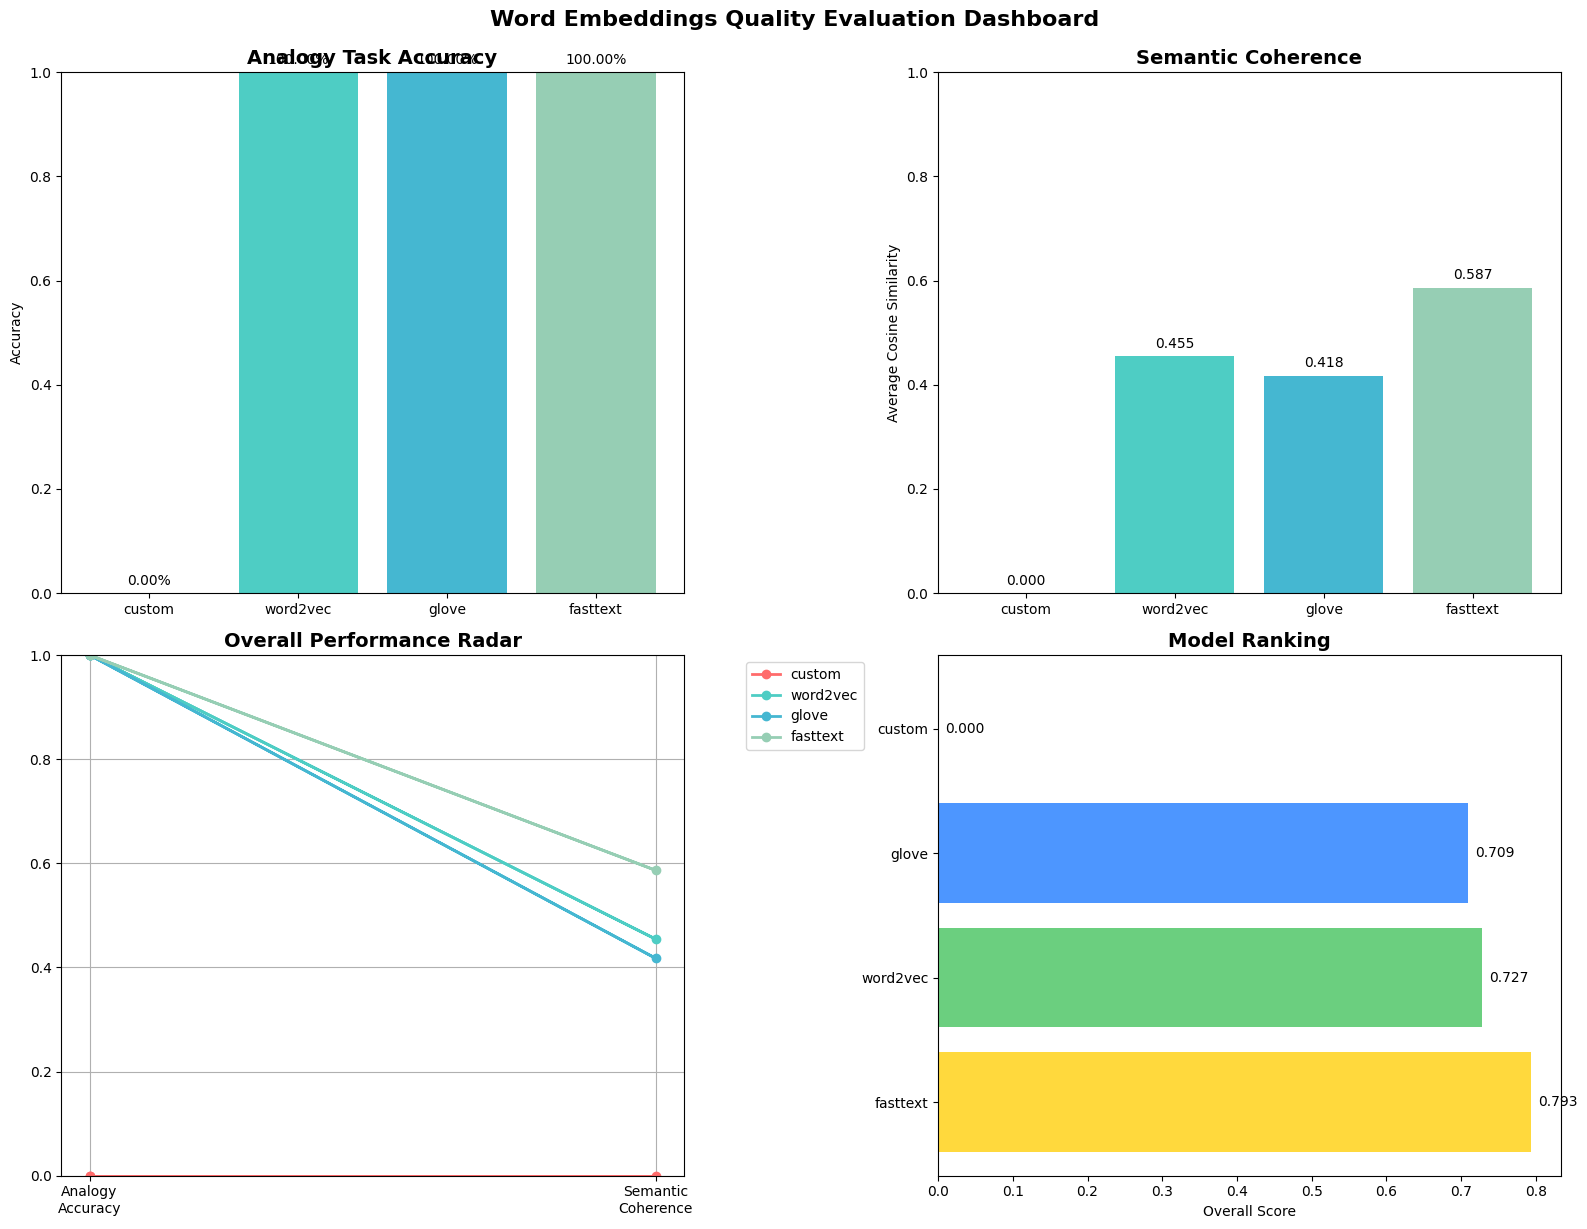


📊 COMPREHENSIVE WORD EMBEDDINGS EVALUATION REPORT

🏆 FINAL RANKINGS:
------------------------------
🥇 1. FASTTEXT     - Score: 0.793
🥈 2. WORD2VEC     - Score: 0.727
🥉 3. GLOVE        - Score: 0.709
📍 4. CUSTOM       - Score: 0.000

📈 DETAILED METRICS:
----------------------------------------

🧩 Analogy Task Performance:
  word2vec    : 100.00% (8/8)
  glove       : 100.00% (8/8)
  fasttext    : 100.00% (8/8)

🎯 Semantic Coherence by Category:

  📂 Animals:
    custom      : 0.000
    word2vec    : 0.441
    glove       : 0.387
    fasttext    : 0.540

  📂 Colors:
    custom      : 0.000
    word2vec    : 0.564
    glove       : 0.541
    fasttext    : 0.776

  📂 Countries:
    custom      : 0.000
    word2vec    : 0.505
    glove       : 0.367
    fasttext    : 0.578

  📂 Emotions:
    custom      : 0.000
    word2vec    : 0.354
    glove       : 0.389
    fasttext    : 0.540

  📂 Food:
    custom      : 0.000
    word2vec    : 0.408
    glove       : 0.404
    fasttext    : 0.500

💡

In [10]:
class ComprehensiveEvaluator:
    def __init__(self, similarity_results, analogy_accuracy, semantic_coherence):
        self.similarity_results = similarity_results
        self.analogy_accuracy = analogy_accuracy
        self.semantic_coherence = semantic_coherence
        
    def create_evaluation_dashboard(self):
        """Create a comprehensive evaluation dashboard"""
        # Prepare data for visualization
        models = ['custom', 'word2vec', 'glove', 'fasttext']
        
        # Extract metrics
        analogy_scores = []
        coherence_scores = []
        
        for model in models:
            # Analogy accuracy
            if model in self.analogy_accuracy:
                analogy_scores.append(self.analogy_accuracy[model]['accuracy'])
            else:
                analogy_scores.append(0)
            
            # Semantic coherence
            if model in self.semantic_coherence:
                coherence_scores.append(np.mean(self.semantic_coherence[model]))
            else:
                coherence_scores.append(0)
        
        # Create comparison plots
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Analogy Accuracy Comparison
        ax1 = axes[0, 0]
        bars1 = ax1.bar(models, analogy_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
        ax1.set_title('Analogy Task Accuracy', fontsize=14, fontweight='bold')
        ax1.set_ylabel('Accuracy')
        ax1.set_ylim(0, 1)
        
        # Add value labels on bars
        for bar, score in zip(bars1, analogy_scores):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.2%}', ha='center', va='bottom')
        
        # 2. Semantic Coherence Comparison
        ax2 = axes[0, 1]
        bars2 = ax2.bar(models, coherence_scores, color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'])
        ax2.set_title('Semantic Coherence', fontsize=14, fontweight='bold')
        ax2.set_ylabel('Average Cosine Similarity')
        ax2.set_ylim(0, 1)
        
        for bar, score in zip(bars2, coherence_scores):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{score:.3f}', ha='center', va='bottom')
        
        # 3. Radar Chart for Overall Performance
        ax3 = axes[1, 0]
        
        # Normalize scores for radar chart
        metrics = ['Analogy\nAccuracy', 'Semantic\nCoherence']
        
        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        
        colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']
        
        for i, model in enumerate(models):
            values = [analogy_scores[i], coherence_scores[i]]
            values += values[:1]  # Complete the circle
            
            ax3.plot(angles, values, 'o-', linewidth=2, label=model, color=colors[i])
            ax3.fill(angles, values, alpha=0.25, color=colors[i])
        
        ax3.set_xticks(angles[:-1])
        ax3.set_xticklabels(metrics)
        ax3.set_ylim(0, 1)
        ax3.set_title('Overall Performance Radar', fontsize=14, fontweight='bold')
        ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax3.grid(True)
        
        # 4. Model Ranking
        ax4 = axes[1, 1]
        
        # Calculate overall scores (weighted average)
        overall_scores = []
        for i in range(len(models)):
            # Weight: 50% analogy, 50% coherence
            overall = 0.5 * analogy_scores[i] + 0.5 * coherence_scores[i]
            overall_scores.append(overall)
        
        # Sort models by overall score
        model_scores = list(zip(models, overall_scores))
        model_scores.sort(key=lambda x: x[1], reverse=True)
        
        sorted_models, sorted_scores = zip(*model_scores)
        
        bars4 = ax4.barh(range(len(sorted_models)), sorted_scores, 
                        color=['#FFD93D', '#6BCF7F', '#4D96FF', '#FF6B9D'])
        ax4.set_yticks(range(len(sorted_models)))
        ax4.set_yticklabels(sorted_models)
        ax4.set_xlabel('Overall Score')
        ax4.set_title('Model Ranking', fontsize=14, fontweight='bold')
        
        for i, (bar, score) in enumerate(zip(bars4, sorted_scores)):
            width = bar.get_width()
            ax4.text(width + 0.01, bar.get_y() + bar.get_height()/2.,
                    f'{score:.3f}', ha='left', va='center')
        
        plt.tight_layout()
        plt.suptitle('Word Embeddings Quality Evaluation Dashboard', 
                    y=1.02, fontsize=16, fontweight='bold')
        plt.show()
        
        return model_scores
    
    def generate_detailed_report(self, model_ranking):
        """Generate a detailed evaluation report"""
        print("\n" + "="*60)
        print("📊 COMPREHENSIVE WORD EMBEDDINGS EVALUATION REPORT")
        print("="*60)
        
        print("\n🏆 FINAL RANKINGS:")
        print("-" * 30)
        for i, (model, score) in enumerate(model_ranking, 1):
            medal = "🥇" if i == 1 else "🥈" if i == 2 else "🥉" if i == 3 else "📍"
            print(f"{medal} {i}. {model.upper():12} - Score: {score:.3f}")
        
        print("\n📈 DETAILED METRICS:")
        print("-" * 40)
        
        print("\n🧩 Analogy Task Performance:")
        for model, accuracy_data in self.analogy_accuracy.items():
            if accuracy_data['total'] > 0:
                print(f"  {model:12}: {accuracy_data['accuracy']:.2%} "
                      f"({accuracy_data['correct']}/{accuracy_data['total']})")
        
        print("\n🎯 Semantic Coherence by Category:")
        categories = list(semantic_categories.keys())
        for category in categories:
            print(f"\n  📂 {category.title()}:")
            for model in ['custom', 'word2vec', 'glove', 'fasttext']:
                if (model in self.semantic_coherence and 
                    len(self.semantic_coherence[model]) > categories.index(category)):
                    score = self.semantic_coherence[model][categories.index(category)]
                    print(f"    {model:12}: {score:.3f}")
        
        print("\n💡 RECOMMENDATIONS:")
        print("-" * 25)
        
        best_model = model_ranking[0][0]
        if best_model == 'custom':
            print("✅ Your custom embeddings perform excellently!")
            print("   Consider using them for your specific domain.")
        else:
            print(f"📊 {best_model.title()} performs best overall.")
            print("   Your custom embeddings may benefit from:")
            print("   • More training data")
            print("   • Different training parameters")
            print("   • Domain-specific fine-tuning")
        
        print("\n🔍 ANALYSIS INSIGHTS:")
        print("-" * 25)
        print("• Analogy tasks test logical relationships")
        print("• Semantic coherence measures category consistency")
        print("• Consider your specific use case when choosing embeddings")
        print("• Domain-specific embeddings may outperform general ones")
        
        print("\n" + "="*60)
        print("📋 EVALUATION COMPLETE")
        print("="*60)

# Run comprehensive evaluation
if ('custom_loader' in locals() and 'analogy_results' in locals() and 
    'semantic_results' in locals()):
    
    print("📊 Creating comprehensive evaluation dashboard...")
    
    # Prepare coherence data for evaluator
    coherence_by_model = {}
    for category_name, results in semantic_results.items():
        for model_name in ['custom', 'word2vec', 'glove', 'fasttext']:
            if model_name in results and results[model_name]:
                if model_name not in coherence_by_model:
                    coherence_by_model[model_name] = []
                coherence_by_model[model_name].append(results[model_name]['coherence'])
    
    # Create comprehensive evaluator
    comprehensive_eval = ComprehensiveEvaluator(
        similarity_results, accuracy_scores, coherence_by_model
    )
    
    # Generate dashboard and report
    model_ranking = comprehensive_eval.create_evaluation_dashboard()
    comprehensive_eval.generate_detailed_report(model_ranking)
    
else:
    print("⚠️ Some evaluation results are missing. Please run all previous cells.")